In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import sys
REV_DIR = os.getcwd()
RES_DIR = os.path.dirname(REV_DIR)
ROOT_DIR = os.path.dirname(RES_DIR)
sys.path.append(ROOT_DIR)

In [3]:
import mlflow
from revision_utils import TRACKING_URI, BOOSTRAP_RUN_ID
from utils.serialization_ops import load_pickle

mlflow.set_tracking_uri(TRACKING_URI)
path = mlflow.artifacts.download_artifacts(
    "mlflow-artifacts:/6/{run_id}/artifacts/fold_result.pickle".format(run_id=BOOSTRAP_RUN_ID)
)
fold_results = load_pickle(path)

/data2/heon_dev/anaconda3/envs/3asc/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


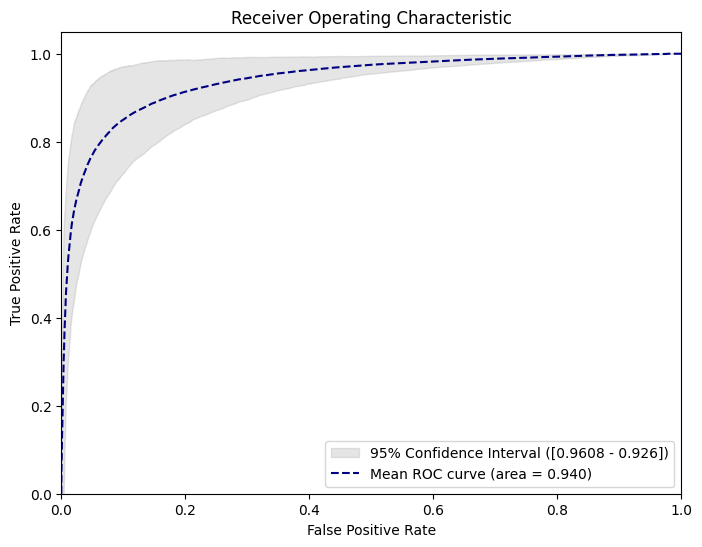

In [4]:
from core.metric import plot_cv_auroc_ci
fold_y_trues = fold_results["fold_bag_y_trues"]
fold_y_probs = fold_results["fold_bag_y_probs"]

plot_cv_auroc_ci(fold_y_trues, fold_y_probs)

In [5]:
# Color change
import seaborn as sns
sns.set_context('paper')
sns.set_color_codes('pastel')

In [6]:
import numpy as np
from core.metric import topk_recall
ks = [1, 2, 3, 4, 5, 10, 15, 20, 100]

n_fold = 30
performance = np.ones((n_fold, len(ks)))

for k_idx, k in enumerate(ks):
    for fold_idx, (instance_y_trues_at_fold, instance_y_probs_at_fold) in enumerate(
        zip(fold_results["fold_instance_y_trues"], fold_results["fold_instance_y_probs"])
    ):
        hits = list()
        for instance_y_true, instance_y_probs in zip(instance_y_trues_at_fold, instance_y_probs_at_fold):
            if instance_y_true.sum() == 0:
                continue

            hit = topk_recall(instance_y_probs, instance_y_true, k=k)
            hits.append(hit)

        performance[fold_idx, k_idx] = sum(hits) / len(hits)

print("-"*30 + "AVG" + "-"*30)
print(performance.mean(axis=0) * 100)
print("-"*30 + "SD" + "-"*30)
print(performance.std(axis=0) * 100)

------------------------------AVG------------------------------
[75.3263761  87.6427256  91.55514631 93.65868631 94.40761203 95.74381011
 96.08553305 96.32289748 97.61203192]
------------------------------SD------------------------------
[1.90814526 1.82236368 1.68717968 1.63119111 1.60324449 1.60551372
 1.54753639 1.52032158 1.39394358]


<Axes: >

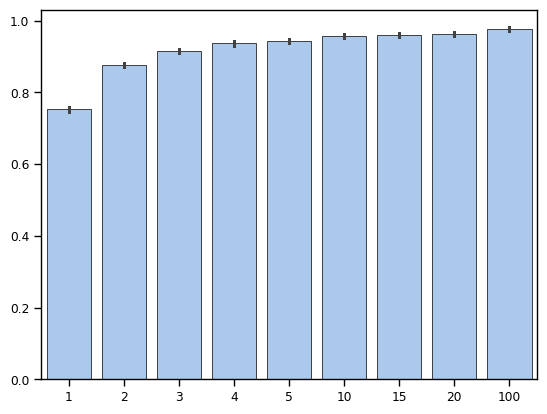

In [7]:
import pandas as pd
from sklearn.model_selection import train_test_split

df = pd.DataFrame(performance, columns=ks)
df.index.name = "fold"
df.to_csv("snv_cnv_topk.csv", index=True)
sns.barplot(df, color="b", edgecolor="black", linewidth=0.5)

SNV only

------------------------------AVG------------------------------
[76.02654041 88.4359332  92.32450881 94.39578477 95.08343391 96.31701123
 96.58791065 96.78775957 97.81895512]
------------------------------SD------------------------------
[2.1020553  1.96356859 1.78898411 1.71112061 1.66542537 1.63092712
 1.59072077 1.56377748 1.39558923]


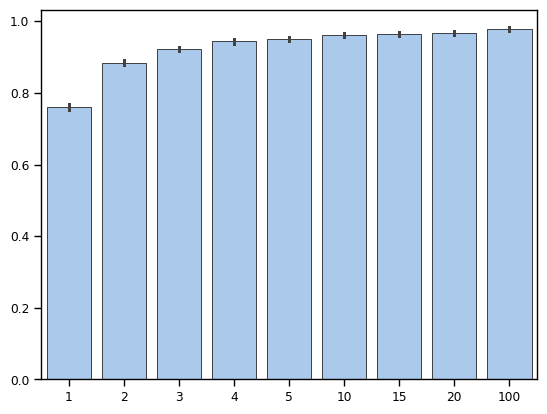

In [12]:
import numpy as np
import pandas as pd
import seaborn as sns

sns.set_context('paper')
sns.set_color_codes('pastel')

from results.revision.revision_utils import get_snv_only_case, DATA_PATH
from core.metric import Metric
from utils.serialization_ops import load_pickle

# patient_dataset = load_pickle(DATA_PATH)

ks = [1, 2, 3, 4, 5, 10, 15, 20, 100]
n_fold = len(fold_results["fold_instance_y_trues"])
performance = np.ones((n_fold, len(ks)))

for k_idx, k in enumerate(ks):
    for fold_idx in range(n_fold):
        test_ids = fold_results["test_ids"][fold_idx]
        snv_only_ids = get_snv_only_case(patient_dataset[test_ids])  
        
        test_indices = [test_ids.index(snv_id) for snv_id in snv_only_ids]

        instance_y_trues = [fold_results["fold_instance_y_trues"][fold_idx][_id] for _id in test_indices]
        instance_y_probs = [fold_results["fold_instance_y_probs"][fold_idx][_id] for _id in test_indices]
        topk = Metric.topk_recall(
            bag_labels=np.ones(len(instance_y_probs)), 
            instance_probs=instance_y_probs, 
            instance_labels=instance_y_trues, 
            k=k,
            is_any=True
        )
    
        performance[fold_idx, k_idx] = topk
        
df = pd.DataFrame(performance, columns=ks)
df.index.name = "fold"
sns.barplot(df, color="b", edgecolor="black", linewidth=0.5)

print("-"*30 + "AVG" + "-"*30)
print(performance.mean(axis=0) * 100)
print("-"*30 + "SD" + "-"*30)
print(performance.std(axis=0) * 100)

Figure 2-C

Loading dataset to count SNV/CNV number


100%|██████████| 30/30 [00:07<00:00,  3.89it/s]


------------------------------AVG------------------------------
[60.9365926  71.31748331 75.81186742 78.13678808 80.43139311 84.15677644
 86.04418864 87.05224209 93.85372628]
------------------------------SD------------------------------
[9.86741361 7.76339363 7.5715357  7.48338619 7.46651541 6.9538447
 6.14137554 5.59050016 4.40722884]


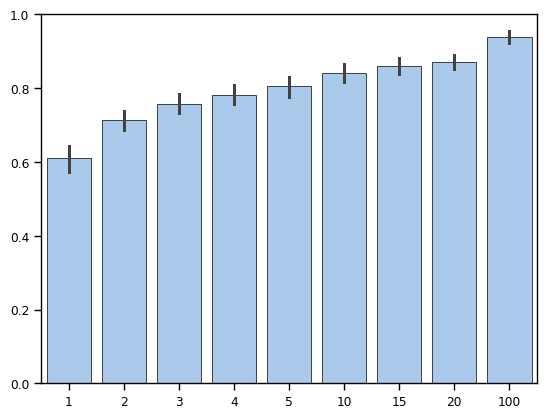

In [11]:
import tqdm
from revision_utils import DATA_PATH
print("Loading dataset to count SNV/CNV number")
dataset = load_pickle(DATA_PATH)


ks = [1, 2, 3, 4, 5, 10, 15, 20, 100]
performance = np.ones((n_fold, len(ks)))

for fold in tqdm.tqdm(range(n_fold)):
    test_ids = fold_results["test_ids"][fold]
    test_dataset = dataset[test_ids]
    instance_y_trues_at_fold = fold_results["fold_instance_y_trues"][fold]
    instance_y_probs_at_fold = fold_results["fold_instance_y_probs"][fold]
    for k_idx, k in enumerate(ks):
        hits = list()
        for instance_y_true, instance_y_probs, patient_data in zip(instance_y_trues_at_fold, instance_y_probs_at_fold, test_dataset):
            if instance_y_true.sum() == 0:
                continue

            if not patient_data.cnv_data.causal_variant:
                continue

            if patient_data.snv_data.causal_variant != [("-", "-")]:
                continue

            hit = topk_recall(instance_y_probs, instance_y_true, k=k)
            hits.append(hit)

        performance[fold, k_idx] = sum(hits) / len(hits)

df = pd.DataFrame(performance, columns=ks)
df.index.name = "fold"
df.to_csv("cnv_topk.csv", index=True)
sns.barplot(df, color="b", edgecolor="black", linewidth=0.5)


print("-"*30 + "AVG" + "-"*30)
print(performance.mean(axis=0) * 100)
print("-"*30 + "SD" + "-"*30)
print(performance.std(axis=0) * 100)